# Amazon Fine Food Review Analysis-Applying Logistic Regression
Objective:Applying Logistic Regression on all four feature generation techniques like Bow,Tfidf,Average Tfidf-Word2vec and Weighted Tfidf-Word2vec for given problem. Used GridsearchCV and RandomsearchCV to find optimal value. L1 and L2 regularier used for each featurization.Showed Sparcity and Multicollinearity for vectorizers.In order to load the data we have used SQLite dataset as it easier to query the data and visualise the data efficiently. 

In [1]:
%matplotlib inline
import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score
from sklearn import metrics
from sklearn.metrics import roc_curve,auc
from nltk.stem.porter import PorterStemmer

from tqdm import tqdm
import os

#Using SQLite table to read data
con = sqlite3.connect('database.sqlite')

#filtering only positive and negative reviews and not taking reviews with score=3
filtered_data=pd.read_sql_query(""" Select * from Reviews Where Score!=3""",con)

#give reviews with score>3 as positive rating and score<3 as negative rating
def partition(x):
    if x<3:
        return 0
    return 1
actualScore = filtered_data['Score']

#changing reviews with score as positve and negative ratings 
positiveNegative= actualScore.map(partition)
filtered_data['Score']= positiveNegative
filtered_data.head(3)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [2]:
filtered_data.shape

(525814, 10)

In [3]:
display = pd.read_sql_query("""select * from Reviews where Score!=3 and Userid="AR5J8UI46CURR" ORDER BY ProductId""",con)
display

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As observed that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text on doing the analysis.

In [4]:
#Sorting data according to ProductId in ascending order
sortedData=filtered_data.sort_values('ProductId',axis=0,kind="quicksort",ascending=True,inplace=False,na_position='last')

In [5]:
#Deduplication of entries
final=sortedData.drop_duplicates(subset={"UserId","ProfileName","Time","Text"},keep='first',inplace=False)
final.shape

(364173, 10)

In [6]:
final['Score'].value_counts()

1    307063
0     57110
Name: Score, dtype: int64

In [7]:
final=final[final.HelpfulnessNumerator <= final.HelpfulnessDenominator]

In [8]:
#sorting data by timestamp for time based slicing.
final = final.sort_values('Time',axis =0, ascending = True, inplace = False, kind="quicksort", na_position = 'last')
final = final.reset_index()
final.head()

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,1,939340800,EVERY book is educational,this witty little book makes my son laugh at l...
1,138683,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,1,940809600,This whole series is great way to spend time w...,I can remember seeing the show when it aired o...
2,417839,451856,B00004CXX9,AIUWLEQ1ADEG5,Elizabeth Medina,0,0,1,944092800,Entertainingl Funny!,Beetlejuice is a well written movie ..... ever...
3,346055,374359,B00004CI84,A344SMIA5JECGM,Vincent P. Ross,1,2,1,944438400,A modern day fairy tale,"A twist of rumplestiskin captured on film, sta..."
4,417838,451855,B00004CXX9,AJH6LUC1UT1ON,The Phantom of the Opera,0,0,1,946857600,FANTASTIC!,Beetlejuice is an excellent and funny movie. K...


In [9]:
final_100k = final.head(100000)

In [10]:
final_100k['Score'].value_counts()

1    87729
0    12271
Name: Score, dtype: int64

# Text Preprocessing:Stemming,Stop-words removal and Lemmatization
1.Begin by removing html tags 2.Remove any punctuations or set of any special characters 3.Check if the word is made up of english letters and is not alpha-numeric 4.Convert the word to lowercase 5.Remove Stopwords 6.Finally snowball stemming the word

In [11]:
import re as standardre
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
stop= set(stopwords.words('english'))#set of stopwords
sno=nltk.stem.SnowballStemmer('english')#initializing the snowball stemmer
def cleanhtml(sentence):#function to clean the word of any html tag
    cleanr=standardre.compile('<.*?>')
    cleantext=standardre.sub(cleanr,' ',sentence)
    return cleantext
def cleanpunc(sentence):#function to clean any punctuation or special characters
    cleaned=standardre.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned=standardre.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return cleaned
print(stop)
print('*******************************************')
print(sno.stem('tasty'))

{'do', 'but', 'of', 'under', 'an', "mightn't", "you'll", 'll', 'themselves', 'ours', "that'll", 'down', 'ma', 've', 'if', 'shan', "you've", 'up', 'own', 'the', "wouldn't", 'few', "mustn't", "you'd", 'yourselves', 'each', 'for', "you're", 'who', 'very', "haven't", 'herself', 'ourselves', "don't", 'being', 'by', 'had', 'our', 'o', 'with', 'these', 'all', 'won', 'myself', 'between', 'only', 'and', "should've", 'whom', 'he', 'didn', 'be', 'm', 'during', 'my', 'theirs', 'most', 'any', 'further', 'then', "it's", 'does', 'are', 'should', 'too', 'been', 'or', 'wasn', 'can', 'wouldn', 'because', 'once', 'as', 'was', 'its', "shouldn't", 'her', 'it', 'having', 'when', 's', "isn't", 'itself', 'don', 'doesn', 'him', 'which', 'from', "didn't", "shan't", 'hasn', 'against', 'a', 'where', 'yourself', 'yours', 'haven', "weren't", 'their', 'ain', "needn't", 'more', 'just', 'this', 'such', 'will', "aren't", 'both', 'on', 'now', 'mightn', 'doing', 'in', 'your', 'hers', 'nor', 'to', 'has', 'other', "hadn't"

In [12]:
from tqdm import tqdm
#code for implementing step-by-step the checks mentioned the pre-processing phase
str1=' '
final_string=[]
all_positive_words=[] # store words from +ve reviews here\n",
all_negative_words=[] # store words from -ve reviews here.\n",
s=''
for i,sent in enumerate(tqdm(final_100k['Text'].values)):
    filtered_sentence=[]
    #print(sent);\n",
    sent=cleanhtml(sent) # remove HTMl tags\n",
    for w in sent.split():
          for cleaned_words in cleanpunc(w).split():
                if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                    if(cleaned_words.lower() not in stop):
                        s=(sno.stem(cleaned_words.lower())).encode('utf8')
                        filtered_sentence.append(s)
                        if (final['Score'].values)[i] == 1: 
                            all_positive_words.append(s) #list of all words used to describe positive reviews\n",
                        if(final['Score'].values)[i] == 0:
                            all_negative_words.append(s) #list of all words used to describe negative reviews reviews\n",
    #print(filtered_sentence)\n",
    str1 = b" ".join(filtered_sentence) #final string of cleaned words
    #print(\"***********************************************************************\")\n",
    final_string.append(str1)
    
final_100k['CleanedText']=final_string #final string of cleaned words storing in a column of cleanedtext
final_100k['CleanedText']=final_100k['CleanedText'].str.decode("utf-8")

100%|█████████████████████████████████| 100000/100000 [04:03<00:00, 410.58it/s]


In [13]:
#Finding most frequently occuring Positive and Negative words
freq_dist_positive=nltk.FreqDist(all_positive_words)
freq_dist_negative=nltk.FreqDist(all_negative_words)
print("Most common positive words:",freq_dist_positive.most_common(20))
print("Most common negative words:",freq_dist_negative.most_common(20))

Most common positive words: [(b'like', 36906), (b'tast', 35305), (b'good', 30952), (b'flavor', 29987), (b'tea', 29849), (b'great', 29549), (b'love', 28267), (b'use', 27551), (b'one', 26049), (b'product', 24778), (b'tri', 23351), (b'make', 21455), (b'get', 18747), (b'coffe', 17729), (b'food', 14715), (b'best', 14690), (b'time', 14674), (b'eat', 14533), (b'buy', 14211), (b'amazon', 14071)]
Most common negative words: [(b'tast', 7223), (b'like', 6590), (b'product', 5935), (b'one', 4429), (b'flavor', 4081), (b'tri', 3696), (b'would', 3646), (b'good', 3265), (b'use', 3054), (b'tea', 2861), (b'buy', 2778), (b'order', 2760), (b'get', 2728), (b'coffe', 2533), (b'dont', 2414), (b'food', 2339), (b'even', 2235), (b'box', 2208), (b'make', 2146), (b'amazon', 2114)]


In [14]:
final_100k.shape

(100000, 12)

In [15]:
from sklearn.cross_validation import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.cross_validation import cross_val_score
from collections import Counter
from sklearn import cross_validation
from sklearn.model_selection import train_test_split

X = final_100k['CleanedText']
print("shape of X:",X.shape)
y = final_100k['Score']
print("shape of y:",y.shape)

shape of X: (100000,)
shape of y: (100000,)


In [16]:
#splitting data into train and test where 80% data used for train and 20% for test model
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=0)

# Feature generation techniques to convert text to vector
Bag Of Words

In [17]:
#generating BOW vector matrix for X_train text reviews
count_vect=CountVectorizer()
X_train_bow = count_vect.fit_transform(X_train)
print("the type of count vectorizer",type(X_train_bow))
print("the shape of X_train BOW vectorizer",X_train_bow.get_shape())
print("the number of unique words",X_train_bow.get_shape()[1])

the type of count vectorizer <class 'scipy.sparse.csr.csr_matrix'>
the shape of X_train BOW vectorizer (80000, 33490)
the number of unique words 33490


In [18]:
X_test_bow = count_vect.transform(X_test)
print("the type of count vectorizer",type(X_test_bow))
print("the shape of X_test BOW vectorizer",X_test_bow.get_shape())
print("the number of unique words",X_test_bow.get_shape()[1])

the type of count vectorizer <class 'scipy.sparse.csr.csr_matrix'>
the shape of X_test BOW vectorizer (20000, 33490)
the number of unique words 33490


In [19]:
X_train_bow[2]

<1x33490 sparse matrix of type '<class 'numpy.int64'>'
	with 21 stored elements in Compressed Sparse Row format>

In [20]:
#Data Preprocessing -> Column Standardization of data
from sklearn import preprocessing
#stand_data = preprocessing.StandardScaler(with_mean=False)
#X_train_bow   = stand_data.fit_transform(X_train_bow)
X_train_bow = preprocessing.normalize(X_train_bow)
print("the shape of standard X_train BOW vectorizer",X_train_bow.get_shape())

the shape of standard X_train BOW vectorizer (80000, 33490)


In [21]:
X_test_bow   = preprocessing.normalize(X_test_bow)
#X_test_bow   = stand_data.fit_transform(X_test_bow)
print("the shape of standard X_test BOW vectorizer",X_test_bow.get_shape())

the shape of standard X_test BOW vectorizer (20000, 33490)


As Observed that Column Normalization taking less time for processing rather than Column Standardization

In [22]:
#To show how Time series splits the data
from sklearn.model_selection import TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)
for train,cv in tscv.split(X_train_bow):
    print("train shape and cv shape",X_train_bow[train].shape,X_train_bow[cv].shape)


train shape and cv shape (13335, 33490) (13333, 33490)
train shape and cv shape (26668, 33490) (13333, 33490)
train shape and cv shape (40001, 33490) (13333, 33490)
train shape and cv shape (53334, 33490) (13333, 33490)
train shape and cv shape (66667, 33490) (13333, 33490)


# Finding Optimal lambda using GridSearchCV and RandomSearchCV
L1,L2 regularizers using time series CV

In [23]:
%%time
#Importing logistic regression gridsearch and randomsearch
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression

#logreg1 = LogisticRegression(penalty='l1')
#logreg2 = LogisticRegression(penalty='l2')
logreg1 = LogisticRegression(class_weight='balanced')
#parameters we need to try on classifier
param_grid = {'C':[1000,500,100,50,10,5,1,0.5,0.1,0.05,0.01,0.005,0.001,0.0005,0.0001], 'penalty':['l1','l2']}
#For time based splitting
tscv = TimeSeriesSplit(n_splits=5)
#performing grid search with l1 regularizer
model1 = GridSearchCV(logreg1,param_grid,cv=tscv,scoring='f1',verbose=1)
model1.fit(X_train_bow,y_train)
#Using grid search to find optimal C or 1/lambda
print("Best Hyper parameter:", model1.best_params_)
print("Best accuracy score:" ,(model1.score(X_test_bow,y_test)*100))

Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:  8.6min finished


Best Hyper parameter: {'C': 50, 'penalty': 'l2'}
Best accuracy score: 93.90179359012055
Wall time: 8min 51s


Best Hyper Parameter C=50 and penalty=L2

Accuracy on test data: 92.75
Precision on test data: 94.76495132127955
Recall on test data: 97.09855782933364
F1-score on test data: 95.91756292584041
Non zero weights: 33490
Confusion Matrix of test data:



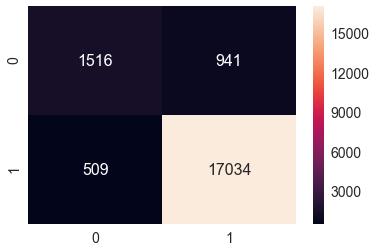

In [24]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
#Testing accuracy on test data
logreg =LogisticRegression(C = 50, penalty = 'l2')
logreg.fit(X_train_bow,y_train)
y_pred = logreg.predict(X_test_bow)
print("Accuracy on test data:",(accuracy_score(y_test,y_pred)*100))
print("Precision on test data:",(precision_score(y_test,y_pred)*100))
print("Recall on test data:",(recall_score(y_test,y_pred)*100))
print("F1-score on test data:",(f1_score(y_test,y_pred)*100))
print("Non zero weights:" ,np.count_nonzero(logreg.coef_))
print("Confusion Matrix of test data:\n")
df_cm = pd.DataFrame(confusion_matrix(y_test,y_pred),range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size":16},fmt='g')

In [25]:
#ROC Score
from sklearn.metrics import roc_auc_score
y_pred = logreg.predict(X_test_bow)
print("AUC" ,roc_auc_score(y_test, y_pred))


AUC 0.7939990976529767


So l1 regularization is often used in LR when we want sparsity.Showing how sparsity increases as we increase lambda or decrease C when L1 regularizer is used

In [26]:
logreg =LogisticRegression(C = 1000 , penalty = 'l1')
logreg.fit(X_train_bow,y_train)
y_pred = logreg.predict(X_test_bow)
print("Accuracy on test data:" ,(accuracy_score(y_test,y_pred)*100))
print("Precision on test data:" ,(precision_score(y_test,y_pred)*100))
print("Recall on test data:" ,(recall_score(y_test,y_pred)*100))
print("F1-score on test data:" ,(f1_score(y_test,y_pred)*100))
print("Non zero weights:" ,np.count_nonzero(logreg.coef_))

Accuracy on test data: 89.225
Precision on test data: 94.13721890775585
Recall on test data: 93.54158353759334
F1-score on test data: 93.83845604002859
Non zero weights: 14387


In [27]:
logreg =LogisticRegression(C = 100 , penalty = 'l1')
logreg.fit(X_train_bow,y_train)
y_pred = logreg.predict(X_test_bow)
print("Accuracy on test data:" ,(accuracy_score(y_test,y_pred)*100))
print("Precision on test data:" ,(precision_score(y_test,y_pred)*100))
print("Recall on test data:" ,(recall_score(y_test,y_pred)*100))
print("F1-score on test data:" ,(f1_score(y_test,y_pred)*100))
print("Non zero weights:" ,np.count_nonzero(logreg.coef_))

Accuracy on test data: 90.975
Precision on test data: 94.61390180292551
Recall on test data: 95.12626118679816
F1-score on test data: 94.86938972740968
Non zero weights: 11168


In [28]:
logreg =LogisticRegression(C = 10 , penalty = 'l1')
logreg.fit(X_train_bow,y_train)
y_pred = logreg.predict(X_test_bow)
print("Accuracy on test data:" ,(accuracy_score(y_test,y_pred)*100))
print("Precision on test data:" ,(precision_score(y_test,y_pred)*100))
print("Recall on test data:" ,(recall_score(y_test,y_pred)*100))
print("F1-score on test data:" ,(f1_score(y_test,y_pred)*100))
print("Non zero weights:" ,np.count_nonzero(logreg.coef_))

Accuracy on test data: 92.86
Precision on test data: 94.86108791269973
Recall on test data: 97.12135894658839
F1-score on test data: 95.97791798107255
Non zero weights: 5475


In [29]:
logreg =LogisticRegression(C = 1 , penalty = 'l1')
logreg.fit(X_train_bow,y_train)
y_pred = logreg.predict(X_test_bow)
print("Accuracy on test data:" ,(accuracy_score(y_test,y_pred)*100))
print("Precision on test data:" ,(precision_score(y_test,y_pred)*100))
print("Recall on test data:" ,(recall_score(y_test,y_pred)*100))
print("F1-score on test data:" ,(f1_score(y_test,y_pred)*100))
print("Non zero weights:" ,np.count_nonzero(logreg.coef_))

Accuracy on test data: 92.67
Precision on test data: 94.02968724324916
Recall on test data: 97.85669497805392
F1-score on test data: 95.90502793296089
Non zero weights: 1084


In [30]:
logreg =LogisticRegression(C = 0.1 , penalty = 'l1')
logreg.fit(X_train_bow,y_train)
y_pred = logreg.predict(X_test_bow)
print("Accuracy on test data:" ,(accuracy_score(y_test,y_pred)*100))
print("Precision on test data:" ,(precision_score(y_test,y_pred)*100))
print("Recall on test data:" ,(recall_score(y_test,y_pred)*100))
print("F1-score on test data:" ,(f1_score(y_test,y_pred)*100))
print("Non zero weights:" ,np.count_nonzero(logreg.coef_))

Accuracy on test data: 90.685
Precision on test data: 91.07722938279366
Recall on test data: 99.08795530981018
F1-score on test data: 94.91386606240958
Non zero weights: 212


In [31]:
logreg =LogisticRegression(C = 0.01 , penalty = 'l1')
logreg.fit(X_train_bow,y_train)
y_pred = logreg.predict(X_test_bow)
print("Accuracy on test data:" ,(accuracy_score(y_test,y_pred)*100))
print("Precision on test data:" ,(precision_score(y_test,y_pred)*100))
print("Recall on test data:" ,(recall_score(y_test,y_pred)*100))
print("F1-score on test data:" ,(f1_score(y_test,y_pred)*100))
print("Non zero weights:" ,np.count_nonzero(logreg.coef_))

Accuracy on test data: 87.715
Precision on test data: 87.715
Recall on test data: 100.0
F1-score on test data: 93.45550435500627
Non zero weights: 13


We can see how  drastically the sparsity decreases or the number of non-zero weights increases from 14435(@ C=1000) to  13 non-zero weights(@ C=0.01) when we use L2 Regularization 

Checking sparsity with differernt values of lambda or C using L1 regularization

In [32]:
c_sparse = np.arange(0,50,0.5)
c_sparse = c_sparse[1:]
c_sparse.shape

(99,)

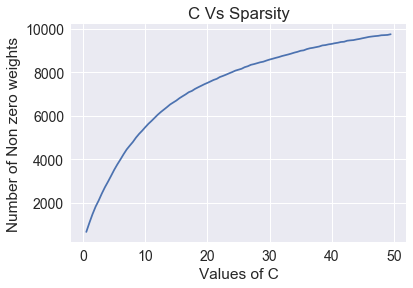

Wall time: 7min 31s


In [33]:
%%time
spc = []#Number of sparsity counts(Non zero weights for a given C)
error = []
for c in c_sparse:
    lr1 = LogisticRegression(penalty='l1',C=c)
    lr1.fit(X_train_bow,y_train)
    score = lr1.score(X_test_bow,y_test)
    error.append(1-score)
    spc.append(np.count_nonzero(lr1.coef_))
#Plotting C vs Sparsity
plt.title("C Vs Sparsity")
plt.xlabel("Values of C")
plt.ylabel("Number of Non zero weights")
plt.plot(c_sparse,spc)
plt.show()

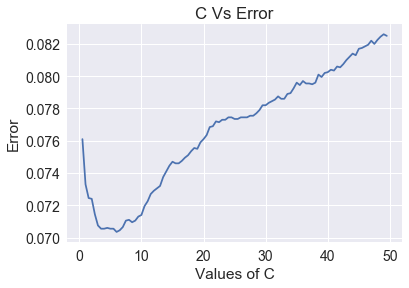

In [34]:
#Plotting C vs Error
plt.title("C Vs Error")
plt.xlabel("Values of C")
plt.ylabel("Error")
plt.plot(c_sparse,error)
plt.show()

Checking sparsity with differernt values of lambda or C using L2 regularization

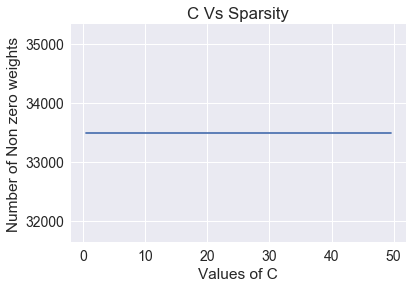

Wall time: 10min 32s


In [35]:
%%time
spc = []#Number of sparsity counts(Non zero weights for a given C)
error = []
for c in c_sparse:
    lr2 = LogisticRegression(penalty='l2',C=c)
    lr2.fit(X_train_bow,y_train)
    score = lr2.score(X_test_bow,y_test)
    error.append(1-score)
    spc.append(np.count_nonzero(lr2.coef_))
#Plotting C vs Sparsity
plt.title("C Vs Sparsity")
plt.xlabel("Values of C")
plt.ylabel("Number of Non zero weights")
plt.plot(c_sparse,spc)
plt.show()

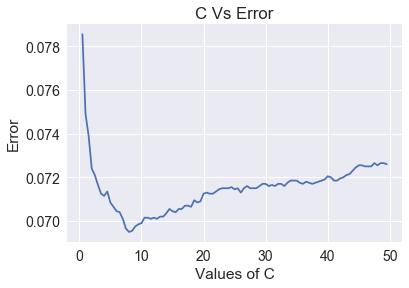

In [36]:
#Plotting C vs Error
plt.title("C Vs Error")
plt.xlabel("Values of C")
plt.ylabel("Error")
plt.plot(c_sparse,error)
plt.show()

Using Randomized SearchCV to find best parameters

In [37]:
%%time
#Importing logistic regression gridsearch and randomsearch
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression

#logreg1 = LogisticRegression(penalty='l1')
#logreg2 = LogisticRegression(penalty='l2')
logreg1 = LogisticRegression()
#parameters we need to try on classifier
param_grid = {'C':[1000,500,100,50,10,5,1,0.5,0.1,0.05,0.01,0.005,0.001,0.0005,0.0001],'penalty':['l1','l2']}
#For time based splitting
tscv = TimeSeriesSplit(n_splits=5)
#performing grid search with l1 regularizer
rs_model1 = RandomizedSearchCV(logreg1,param_grid,cv=tscv,verbose=1)
rs_model1.fit(X_train_bow,y_train)
#Using grid search to find optimal C or 1/lambda
print("Best Hyper parameter:", rs_model1.best_params_)
print("Best accuracy score:" ,(rs_model1.best_score_*100))#rs_model1.score(X_test_bow,y_test)*100

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:  3.8min finished


Best Hyper parameter: {'penalty': 'l2', 'C': 50}
Best accuracy score: 92.23430585764643
Wall time: 3min 53s


For a given parameter list RandomizedSearchCV is sampled uniformly, only fixed number of parameters are tried out.

Best Hyper Parameter C = 50 and penalty = L2

Accuracy on test data: 92.75
Precision on test data: 94.76495132127955
Recall on test data: 97.09855782933364
F1-score on test data: 95.91756292584041
Non zero weights: 33490
Confusion Matrix of test data:



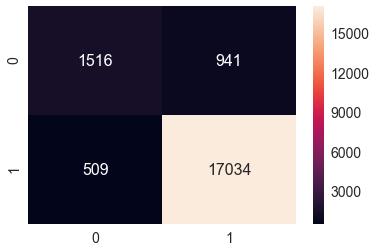

In [38]:
#Testing accuracy on test data
logreg =LogisticRegression(C = 50, penalty = 'l2')
logreg.fit(X_train_bow,y_train)
y_pred = logreg.predict(X_test_bow)
print("Accuracy on test data:" ,(accuracy_score(y_test,y_pred)*100))
print("Precision on test data:" ,(precision_score(y_test,y_pred)*100))
print("Recall on test data:" ,(recall_score(y_test,y_pred)*100))
print("F1-score on test data:" ,(f1_score(y_test,y_pred)*100))
print("Non zero weights:" ,np.count_nonzero(logreg.coef_))
print("Confusion Matrix of test data:\n")
df_cm = pd.DataFrame(confusion_matrix(y_test,y_pred),range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size":16},fmt='g')

In [39]:
logreg =LogisticRegression(C = 1 , penalty = 'l1')
logreg.fit(X_train_bow,y_train)
y_pred = logreg.predict(X_test_bow)
print("Accuracy on test data:" ,(accuracy_score(y_test,y_pred)*100))
print("Precision on test data:" ,(precision_score(y_test,y_pred)*100))
print("Recall on test data:" ,(recall_score(y_test,y_pred)*100))
print("F1-score on test data:" ,(f1_score(y_test,y_pred)*100))
print("Non zero weights:" ,np.count_nonzero(logreg.coef_))

Accuracy on test data: 92.67
Precision on test data: 94.02968724324916
Recall on test data: 97.85669497805392
F1-score on test data: 95.90502793296089
Non zero weights: 1085


# Performing Perturbation Test

In [40]:
lr1 = LogisticRegression(penalty='l2',C=50,class_weight='balanced')
lr1.fit(X_train_bow,y_train)
y_pred = lr1.predict(X_test_bow)
print("Accuracy on test data" ,accuracy_score(y_test,y_pred)*100)
print("Non zero weights are:", np.count_nonzero(lr1.coef_))

Accuracy on test data 89.63
Non zero weights are: 33490


In [41]:
from scipy.sparse import find
#weights before adding random noise
weights1 = find(lr1.coef_[0])[2]
print(weights1[:50])

[-8.64154476e-01  2.19049370e-01  2.53331679e-01  7.78881795e-03
  5.82759092e-02  2.91425135e-01  4.05190168e-02 -1.72395286e+00
  1.43961729e-01  3.43638392e-03  2.06271628e-03 -3.08442517e+00
  1.10774821e+00  1.26061119e+00  2.81335118e-02  1.57306299e-01
  3.82583612e-02  2.30942754e+00  2.55964062e+00 -3.68191658e+00
 -4.81215454e+00  4.27199770e-02  2.09671205e-01  8.92264932e-01
  5.00388130e-01  6.55195807e-01 -2.39906881e-01  2.03421287e-01
  1.81408204e-01  7.22382629e-02  4.67027580e-02 -1.03598829e-01
  4.26766766e+00  2.75907974e-01  2.80559109e-02  7.32603146e-02
 -6.24920669e-03  7.07724528e-02  4.00919080e+00  8.50809334e-02
  5.22370929e+00 -3.94536661e+00  4.08760268e-03  6.45921882e-03
  1.16618879e+00 -2.83617299e+00  1.14266503e-01  1.48785224e+00
  5.07159030e-02 -1.90648411e+00]


In [42]:
find(weights1)

(array([0, 0, 0, ..., 0, 0, 0], dtype=int32),
 array([    0,     1,     2, ..., 33487, 33488, 33489], dtype=int32),
 array([-8.64154476e-01,  2.19049370e-01,  2.53331679e-01, ...,
        -1.09749285e+00,  4.36012710e-04,  4.90458509e-02]))

In [43]:
lr1.coef_

array([[-8.64154476e-01,  2.19049370e-01,  2.53331679e-01, ...,
        -1.09749285e+00,  4.36012710e-04,  4.90458509e-02]])

In [44]:
#print(X_train_bow.toarray())
X_train_boweps = X_train_bow
#getting the positions(row and column) and the value of non-zero elements
#a,b,c = find(X_train_eps)

In [45]:
print(X_train_boweps)

  (0, 2976)	0.18569533817705186
  (0, 4248)	0.18569533817705186
  (0, 8081)	0.18569533817705186
  (0, 8713)	0.18569533817705186
  (0, 10623)	0.18569533817705186
  (0, 11011)	0.18569533817705186
  (0, 13194)	0.18569533817705186
  (0, 13364)	0.18569533817705186
  (0, 13373)	0.18569533817705186
  (0, 13695)	0.18569533817705186
  (0, 14725)	0.18569533817705186
  (0, 16818)	0.18569533817705186
  (0, 17194)	0.18569533817705186
  (0, 17536)	0.18569533817705186
  (0, 22707)	0.18569533817705186
  (0, 23052)	0.3713906763541037
  (0, 23957)	0.3713906763541037
  (0, 24468)	0.18569533817705186
  (0, 25983)	0.18569533817705186
  (0, 27348)	0.18569533817705186
  (0, 29390)	0.18569533817705186
  (0, 30569)	0.18569533817705186
  (0, 32805)	0.18569533817705186
  (1, 44)	0.14907119849998599
  (1, 1530)	0.14907119849998599
  :	:
  (79997, 19972)	0.21320071635561041
  (79997, 20519)	0.21320071635561041
  (79997, 20584)	0.21320071635561041
  (79997, 23390)	0.21320071635561041
  (79997, 23406)	0.426401432711

In [46]:
#Adding noise to the train data to get new train data set
#X_train_bow = X_train_bow.todense()
epsilon = 0.01
#X_train_tfidfeps[a,b] = epsilon + X_train_tfidfeps[a,b]
X_train_boweps.data += epsilon
X_train_boweps.shape

(80000, 33490)

In [47]:
print(X_train_boweps)

  (0, 2976)	0.19569533817705187
  (0, 4248)	0.19569533817705187
  (0, 8081)	0.19569533817705187
  (0, 8713)	0.19569533817705187
  (0, 10623)	0.19569533817705187
  (0, 11011)	0.19569533817705187
  (0, 13194)	0.19569533817705187
  (0, 13364)	0.19569533817705187
  (0, 13373)	0.19569533817705187
  (0, 13695)	0.19569533817705187
  (0, 14725)	0.19569533817705187
  (0, 16818)	0.19569533817705187
  (0, 17194)	0.19569533817705187
  (0, 17536)	0.19569533817705187
  (0, 22707)	0.19569533817705187
  (0, 23052)	0.38139067635410373
  (0, 23957)	0.38139067635410373
  (0, 24468)	0.19569533817705187
  (0, 25983)	0.19569533817705187
  (0, 27348)	0.19569533817705187
  (0, 29390)	0.19569533817705187
  (0, 30569)	0.19569533817705187
  (0, 32805)	0.19569533817705187
  (1, 44)	0.159071198499986
  (1, 1530)	0.159071198499986
  :	:
  (79997, 19972)	0.22320071635561042
  (79997, 20519)	0.22320071635561042
  (79997, 20584)	0.22320071635561042
  (79997, 23390)	0.22320071635561042
  (79997, 23406)	0.43640143271122

In [48]:
#Training on train data with random noise
lr2 = LogisticRegression(penalty='l2',C=50,class_weight='balanced')
lr2.fit(X_train_boweps,y_train)
y_pred = lr2.predict(X_test_bow)
print("Accuracy on test data" ,accuracy_score(y_test,y_pred)*100)
print("Non zero weights are:", np.count_nonzero(lr2.coef_))

Accuracy on test data 89.575
Non zero weights are: 33490


In [49]:
from scipy.sparse import find
#weights before adding random noise
weights2 = find(lr2.coef_[0])[2]
print(weights2[:50])

[-8.64544561e-01  2.24011115e-01  2.64392752e-01  7.87748359e-03
  6.58350884e-02  3.19975998e-01  3.64384386e-02 -1.68914095e+00
  1.24971906e-01  3.23201800e-03  1.40664565e-03 -3.41562360e+00
  1.25341404e+00  1.28139695e+00  2.90276799e-02  1.71862297e-01
  3.47031902e-02  2.40655909e+00  2.54577805e+00 -3.54913354e+00
 -4.82913064e+00  4.13469402e-02  2.01959982e-01  8.60739944e-01
  5.22194991e-01  6.07843742e-01 -2.76749735e-01  1.88438233e-01
  3.49181531e-01  6.50597617e-02  4.78868695e-02 -1.26852841e-01
  4.26999428e+00  2.44582142e-01  2.64209444e-02  4.74491893e-02
 -4.23268122e-03  5.65011396e-02  4.20568169e+00  9.32409838e-02
  5.05562243e+00 -4.06940470e+00  3.17653526e-03  6.78479296e-03
  1.10848527e+00 -2.86875925e+00  1.11618607e-01  1.54449974e+00
  4.36935119e-02 -1.85504520e+00]


In [50]:
lr2.coef_

array([[-8.64544561e-01,  2.24011115e-01,  2.64392752e-01, ...,
        -1.14884374e+00,  3.34920837e-04,  5.44306957e-02]])

In [51]:
weights1 = weights1 + 0.000001

In [52]:
weights2 = weights2 + 0.000001

In [53]:
percentage_change_vector = ((abs(weights1 - weights2)/(weights1))*100)
print(percentage_change_vector)

[-0.0451407   2.26511574  4.36622457 ... -4.67893173 23.13247876
 10.97898175]


Calculating percentiles of percentage_change_vector

In [54]:
print("\n Percentiles:")
print(np.percentile(percentage_change_vector,np.arange(0,110,10)))


 Percentiles:
[-3.38501627e+03 -4.98126384e+00 -1.11986599e+00  7.83942841e-01
  2.09528205e+00  3.60022106e+00  5.46421858e+00  8.03081784e+00
  1.24992116e+01  2.15373552e+01  3.40354612e+04]


In [55]:
print("\n 99th Percentiles:")
print(np.percentile(percentage_change_vector,np.arange(99.1,100,0.1)))


 99th Percentiles:
[   58.6582309     60.83983038    63.75244778    67.85294156
    72.48824264    79.7202365    104.2174697    167.87850749
   389.56192535 34035.46116983]


There is a sudden rise from 104 to 167, so the %change between these two is 64.
Now finding number of features have weight changes greater than 64% are shown below.

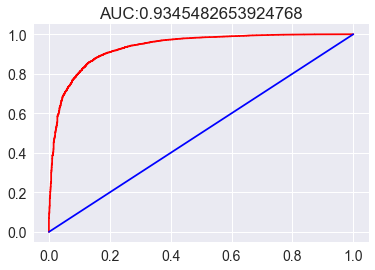

In [56]:
from sklearn.metrics import roc_curve, auc

def plot_roc_auc(actual, preds):
    fpr, tpr, thresholds = roc_curve(actual, preds[:,1])
    plt.plot(fpr,tpr,'r')
    plt.plot([0,1],[0,1],'b')
    plt.title('AUC:{}'.format(auc(fpr,tpr)))
    plt.show()

plot_roc_auc(y_test,lr1.predict_proba(X_test_bow))

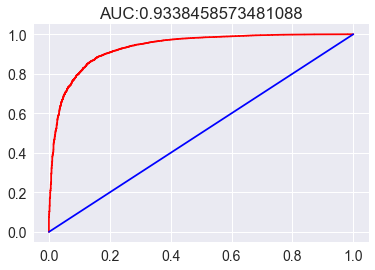

In [57]:
from sklearn.metrics import roc_curve, auc

def plot_roc_auc(actual, preds):
    fpr, tpr, thresholds = roc_curve(actual, preds[:,1])
    plt.plot(fpr,tpr,'r')
    plt.plot([0,1],[0,1],'b')
    plt.title('AUC:{}'.format(auc(fpr,tpr)))
    plt.show()

plot_roc_auc(y_test,lr2.predict_proba(X_test_bow))

In [58]:
print(percentage_change_vector[np.where(percentage_change_vector > 64)].size)

234


234 features have weight changes greater than 64% so features are multicollinear

# Feature Importance
Multicolinearity

In [59]:
#Creating a dataframe with feature weights
#df = pd.DataFrame(data = lr2.coef_.reshape(-1,1),index = count_vect.get_feature_names())
word = count_vect.get_feature_names()
coef = lr2.coef_.tolist()[0]
coef_df = pd.DataFrame({'Words':word, 'Coefficient':coef})
coef_df = coef_df.sort_values(['Coefficient','Words'], ascending=[0, 1]) 

In [60]:
#Most important top 20 Positive feature
print("Top 20 Positive Features")
print(coef_df.head(20).to_string(index=False))

Top 20 Positive Features
Words  Coefficient
  skeptic    16.953925
     solv    14.416623
     beat    13.451675
   poster    13.312225
    inhal    13.189310
     hook    13.039444
  landfil    12.787787
    uniqu    12.735989
  downsid    12.684140
    sneak    12.514196
   awesom    12.372326
  refresh    12.306600
   addict    12.196418
    divin    12.070184
     amaz    11.739322
     rack    11.734318
   advanc    11.694113
primarili    11.585829
 boullion    11.419685
     task    11.418316


In [61]:
#Most important top 20 Negative feature
print("Top 20 Negative Features")
print(coef_df.tail(20).to_string(index=False))

Top 20 Negative Features
Words  Coefficient
   wunderbar   -15.222572
     puberti   -15.336574
  beautifuli   -15.413575
      wanker   -15.526081
    saucepan   -15.591552
        hime   -15.822068
     dorothi   -16.152893
     compass   -16.243111
         udi   -16.768369
yadayadayada   -16.804827
        coil   -16.871130
       midst   -17.445482
   weeknight   -17.551621
    simmilar   -17.860548
       thamk   -18.120135
      cosmos   -18.464001
     disastr   -19.047408
   sleepless   -21.821972
     finnish   -24.410196
       worst   -25.999560


# Feature generation techniques to convert text to vector
TF-IDF

In [62]:
X = final_100k['CleanedText']
print("shape of X:",X.shape)
y = final_100k['Score']
print("shape of y:",y.shape)

#splitting data into train and test where 80% data used for train and 20% for test model
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=0)

shape of X: (100000,)
shape of y: (100000,)


In [63]:
#generating BOW vector matrix for X_train text reviews
tfidf_vect=TfidfVectorizer(ngram_range=(1,2))
X_train_tfidf = tfidf_vect.fit_transform(X_train)
print("the type of count vectorizer",type(X_train_tfidf))
print("the shape of X_train TFIDF vectorizer",X_train_tfidf.get_shape())
print("the number of unique words",X_train_tfidf.get_shape()[1])

the type of count vectorizer <class 'scipy.sparse.csr.csr_matrix'>
the shape of X_train TFIDF vectorizer (80000, 1021721)
the number of unique words 1021721


In [64]:
X_test_tfidf = tfidf_vect.transform(X_test)
print("the type of count vectorizer",type(X_test_tfidf))
print("the shape of X_train TFIDF vectorizer",X_test_tfidf.get_shape())
print("the number of unique words",X_test_tfidf.get_shape()[1])

the type of count vectorizer <class 'scipy.sparse.csr.csr_matrix'>
the shape of X_train TFIDF vectorizer (20000, 1021721)
the number of unique words 1021721


In [65]:
#Data Preprocessing -> Column Standardization of data
from sklearn import preprocessing
#stand_data = preprocessing.StandardScaler(with_mean=False)
#X_train_bow   = stand_data.fit_transform(X_train_bow)
X_train_tfidf = preprocessing.normalize(X_train_tfidf)
print("the shape of standard X_train BOW vectorizer",X_train_tfidf.get_shape())

the shape of standard X_train BOW vectorizer (80000, 1021721)


In [66]:
#X_test_tfidf   = stand_scaler.fit_transform(X_test_tfidf)
X_test_tfidf = preprocessing.normalize(X_test_tfidf)
print("the shape of standard X_test TFIDF vectorizer",X_test_tfidf.get_shape())

the shape of standard X_test TFIDF vectorizer (20000, 1021721)


In [67]:
#To show how Time series splits the data
from sklearn.model_selection import TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)
for train,cv in tscv.split(X_train_tfidf):
    print("train shape and cv shape",X_train_tfidf[train].shape,X_train_tfidf[cv].shape)

train shape and cv shape (13335, 1021721) (13333, 1021721)
train shape and cv shape (26668, 1021721) (13333, 1021721)
train shape and cv shape (40001, 1021721) (13333, 1021721)
train shape and cv shape (53334, 1021721) (13333, 1021721)
train shape and cv shape (66667, 1021721) (13333, 1021721)


# Finding Optimal lambda using GridSearchCV and RandomSearchCV
L1,L2 regularizers using time series CV

In [68]:
%%time
#Importing logistic regression gridsearch and randomsearch
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression

#logreg1 = LogisticRegression(penalty='l1')
#logreg2 = LogisticRegression(penalty='l2')
#parameters we need to try on classifier
param_grid = [{'C':[1000,500,100,50,10,5,1,0.5,0.1,0.05,0.01,0.005,0.001,0.0005,0.0001], 'penalty':['l1','l2']}]
#For time based splitting
tscv = TimeSeriesSplit(n_splits=5)
#performing grid search with l1 regularizer
model1 = GridSearchCV(logreg1,param_grid,cv=tscv,scoring='f1',verbose=1)
model1.fit(X_train_tfidf,y_train)
#Using grid search to find optimal C or 1/lambda
print("Best Hyper parameter:", model1.best_params_)
print("Best accuracy score:" ,(model1.best_score_*100))

Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed: 17.9min finished


Best Hyper parameter: {'C': 5, 'penalty': 'l1'}
Best accuracy score: 96.07739323882214
Wall time: 17min 59s


best hyper parameter C = 5 and penalty=L1

Accuracy on test data: 93.53
Precision on test data: 95.2946423593689
Recall on test data: 97.43487430884113
F1-score on test data: 96.35287485907553
Non zero weights: 6778
Confusion Matrix of test data:



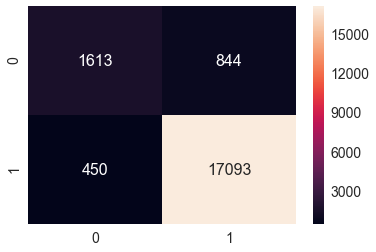

In [69]:
#Testing accuracy on test data
logreg =LogisticRegression(C = 5, penalty = 'l1')
logreg.fit(X_train_tfidf,y_train)
y_pred = logreg.predict(X_test_tfidf)
print("Accuracy on test data:" ,(accuracy_score(y_test,y_pred)*100))
print("Precision on test data:" ,(precision_score(y_test,y_pred)*100))
print("Recall on test data:" ,(recall_score(y_test,y_pred)*100))
print("F1-score on test data:" ,(f1_score(y_test,y_pred)*100))
print("Non zero weights:" ,np.count_nonzero(logreg.coef_))
print("Confusion Matrix of test data:\n")
df_cm = pd.DataFrame(confusion_matrix(y_test,y_pred),range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size":16},fmt='g')

In [70]:
logreg =LogisticRegression(C = 5 , penalty = 'l2')
logreg.fit(X_train_tfidf,y_train)
y_pred = logreg.predict(X_test_tfidf)
print("Accuracy on test data:" ,(accuracy_score(y_test,y_pred)*100))
print("Precision on test data:" ,(precision_score(y_test,y_pred)*100))
print("Recall on test data:" ,(recall_score(y_test,y_pred)*100))
print("F1-score on test data:" ,(f1_score(y_test,y_pred)*100))
print("Non zero weights:" ,np.count_nonzero(logreg.coef_))

Accuracy on test data: 93.39
Precision on test data: 94.24954989361122
Recall on test data: 98.47232514393205
F1-score on test data: 96.31467439785905
Non zero weights: 1021721


Checking sparsity with differernt values of lambda or C

In [71]:
c_sparse = np.arange(0,50,0.5)
c_sparse = c_sparse[1:]
c_sparse.shape

(99,)

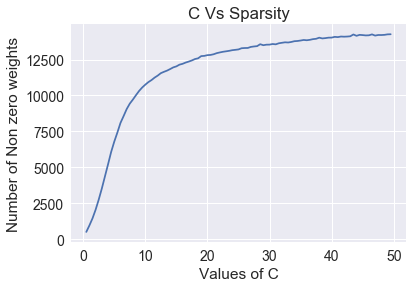

In [72]:
spc = []#Number of sparsity counts(Non zero weights for a given C)
error = []
for c in c_sparse:
    lr = LogisticRegression(penalty='l1',C=c)
    lr.fit(X_train_tfidf,y_train)
    error.append(1-lr.score(X_test_tfidf,y_test))
    spc.append(np.count_nonzero(lr.coef_))
#Plotting C vs Sparsity
plt.title("C Vs Sparsity")
plt.xlabel("Values of C")
plt.ylabel("Number of Non zero weights")
plt.plot(c_sparse,spc)
plt.show()

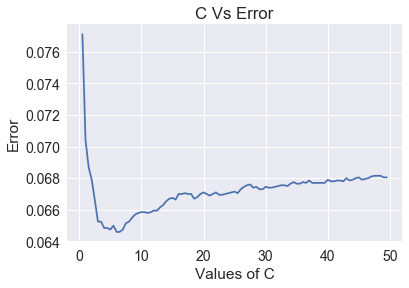

In [73]:
#Plotting C vs Sparsity
plt.title("C Vs Error")
plt.xlabel("Values of C")
plt.ylabel("Error")
plt.plot(c_sparse,error)
plt.show()

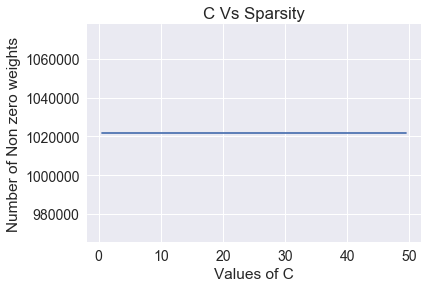

In [74]:
spc = []#Number of sparsity counts(Non zero weights for a given C)
error = []
for c in c_sparse:
    lr = LogisticRegression(penalty='l2',C=c)
    lr.fit(X_train_tfidf,y_train)
    error.append(1-lr.score(X_test_tfidf,y_test))
    spc.append(np.count_nonzero(lr.coef_))
#Plotting C vs Sparsity
plt.title("C Vs Sparsity")
plt.xlabel("Values of C")
plt.ylabel("Number of Non zero weights")
plt.plot(c_sparse,spc)
plt.show()

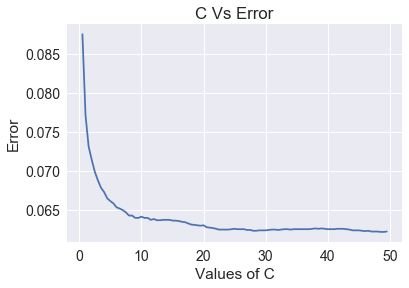

In [75]:
#Plotting C vs Sparsity
plt.title("C Vs Error")
plt.xlabel("Values of C")
plt.ylabel("Error")
plt.plot(c_sparse,error)
plt.show()

In [141]:
%%time
#Importing logistic regression gridsearch and randomsearch
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression

#logreg1 = LogisticRegression(penalty='l1')
#logreg2 = LogisticRegression(penalty='l2')
#parameters we need to try on classifier
param_grid = {'C':[1000,500,100,50,10,5,1,0.5,0.1,0.05,0.01,0.005,0.001,0.0005,0.0001], 'penalty':['l1','l2']}
#For time based splitting
tscv = TimeSeriesSplit(n_splits=5)
#performing random search with l1 regularizer
model1 = RandomizedSearchCV(logreg1,param_grid,cv=tscv,scoring='f1',verbose=1)
model1.fit(X_train_tfidf,y_train)
#Using random search to find optimal C or 1/lambda
print("Best Hyper parameter:", model1.best_params_)
print("Best accuracy score:" ,(model1.best_score_*100))

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:  3.2min finished


Best Hyper parameter: {'penalty': 'l2', 'C': 100}
Best accuracy score: 96.01412128425005
Wall time: 3min 22s


best hyper parameter C=100 and penalty=L2

Accuracy on test data: 93.765
Precision on test data: 94.74956063268893
Recall on test data: 98.34121871971728
F1-score on test data: 96.51198567872228
Non zero weights: 1021721
Confusion Matrix of test data:



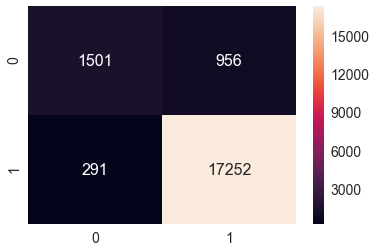

In [142]:
#Testing accuracy on test data
logreg =LogisticRegression(C = 100, penalty = 'l2')
logreg.fit(X_train_tfidf,y_train)
y_pred = logreg.predict(X_test_tfidf)
print("Accuracy on test data:" ,(accuracy_score(y_test,y_pred)*100))
print("Precision on test data:" ,(precision_score(y_test,y_pred)*100))
print("Recall on test data:" ,(recall_score(y_test,y_pred)*100))
print("F1-score on test data:" ,(f1_score(y_test,y_pred)*100))
print("Non zero weights:" ,np.count_nonzero(logreg.coef_))
print("Confusion Matrix of test data:\n")
df_cm = pd.DataFrame(confusion_matrix(y_test,y_pred),range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size":16},fmt='g')

In [79]:
#ROC Score
from sklearn.metrics import roc_auc_score
y_pred = logreg.predict(X_test_tfidf)
print("AUC" ,roc_auc_score(y_test, y_pred))

AUC 0.8179750710104697


In [80]:
logreg =LogisticRegression(C = 5 , penalty = 'l2')
logreg.fit(X_train_tfidf,y_train)
y_pred = logreg.predict(X_test_tfidf)
print("Accuracy on test data:" ,(accuracy_score(y_test,y_pred)*100))
print("Precision on test data:" ,(precision_score(y_test,y_pred)*100))
print("Recall on test data:" ,(recall_score(y_test,y_pred)*100))
print("F1-score on test data:" ,(f1_score(y_test,y_pred)*100))
print("Non zero weights:" ,np.count_nonzero(logreg.coef_))

Accuracy on test data: 93.53
Precision on test data: 95.28959250794358
Recall on test data: 97.44057458815482
F1-score on test data: 96.35308043515022
Non zero weights: 6779


In [81]:
logreg =LogisticRegression(C = 10 , penalty = 'l1')
logreg.fit(X_train_tfidf,y_train)
y_pred = logreg.predict(X_test_tfidf)
print("Accuracy on test data:" ,(accuracy_score(y_test,y_pred)*100))
print("Precision on test data:" ,(precision_score(y_test,y_pred)*100))
print("Recall on test data:" ,(recall_score(y_test,y_pred)*100))
print("F1-score on test data:" ,(f1_score(y_test,y_pred)*100))
print("Non zero weights:" ,np.count_nonzero(logreg.coef_))

Accuracy on test data: 93.42
Precision on test data: 95.36990437845999
Recall on test data: 97.21826369492105
F1-score on test data: 96.28521424942133
Non zero weights: 10739


# Performing Perturbation Test

In [82]:
lr1 = LogisticRegression(penalty='l2',C=5)
lr1.fit(X_train_tfidf,y_train)
y_pred = lr1.predict(X_test_tfidf)
print("Accuracy on test data" ,accuracy_score(y_test,y_pred)*100)
print("Non zero weights are:", np.count_nonzero(lr1.coef_))

Accuracy on test data 93.39
Non zero weights are: 1021721


In [83]:
from scipy.sparse import find
#weights before adding random noise
weights1 = find(lr1.coef_[0])[2]
print(weights1[:50])

[-0.11065345  0.01043315 -0.13679608  0.00867513  0.01602074  0.0422824
  0.01376184  0.03005249  0.01783398  0.01783398  0.00235416  0.00235416
  0.03217643  0.01433734  0.0051184   0.01476618  0.00825823  0.00825823
 -0.14567652 -0.14567652  0.01944693  0.01944693  0.00644061  0.00625251
  0.00625251 -0.24307165  0.00187038 -0.07914852  0.00187038 -0.23387557
  0.00261024  0.0055114   0.03356086  0.06728871  0.06728871  0.15073324
  0.00704908  0.11173333  0.0083589   0.00826848  0.00826848  0.03231783
  0.03231783  0.0185706   0.0185706   0.15523245  0.15523245  0.16063523
  0.00483284  0.05892017]


In [84]:
lr1.coef_

array([[-0.11065345,  0.01043315, -0.13679608, ...,  0.00376243,
         0.00376243,  0.01367999]])

In [85]:
#print(X_train_tfidf.toarray())
X_train_tfidfeps = X_train_tfidf
#getting the positions(row and column) and the value of non-zero elements
#a,b,c = find(X_train_tfidfeps)

In [86]:
#Adding noise to the train data to get new train data set
#X_train_bow = X_train_bow.todense()
epsilon = 0.01
#X_train_tfidfeps[a,b] = epsilon + X_train_tfidfeps[a,b]
X_train_tfidfeps.data += epsilon
X_train_tfidfeps.shape

(80000, 1021721)

In [87]:
#Training on train data with random noise
lr2 = LogisticRegression(penalty='l2',C=5)
lr2.fit(X_train_tfidfeps,y_train)
y_pred = lr2.predict(X_test_tfidf)
print("Accuracy on test data", accuracy_score(y_test,y_pred)*100)
print("Non zero weights are:", np.count_nonzero(lr2.coef_))

Accuracy on test data 93.395
Non zero weights are: 1021721


In [88]:
from scipy.sparse import find
#weights before adding random noise
weights2 = find(lr2.coef_[0])[2]
print(weights2[:50])

[-0.10971507  0.01011469 -0.13314646  0.00688959  0.01548306  0.04075054
  0.01204399  0.03010242  0.01573299  0.01573299  0.00225911  0.00225911
  0.0281012   0.01000246  0.00399425  0.01574352  0.00615674  0.00615674
 -0.13485968 -0.13485968  0.01635303  0.01635303  0.00576506  0.00454967
  0.00454967 -0.26596913  0.00094759 -0.10232561  0.00094759 -0.22453037
  0.00204479  0.00399237  0.03126285  0.07221614  0.07221614  0.15321823
  0.00510568  0.1192846   0.00757239  0.00693267  0.00693267  0.03031101
  0.03031101  0.01693349  0.01693349  0.16489724  0.16489724  0.15396372
  0.00412932  0.05983627]


In [89]:
lr2.coef_

array([[-0.10971507,  0.01011469, -0.13314646, ...,  0.00258274,
         0.00258274,  0.01232063]])

In [90]:
weights1 = weights1 + 0.000001

In [91]:
weights2 = weights2 + 0.000001

In [92]:
weights_diff = ((abs(weights1 - weights2)/(weights1))*100)
print(weights_diff)

[-0.84804044  3.05208686 -2.66795246 ... 31.34604826 31.34604826
  9.93613189]


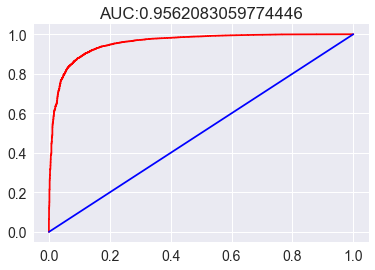

In [98]:
from sklearn.metrics import roc_curve, auc

def plot_roc_auc(actual, preds):
    fpr, tpr, thresholds = roc_curve(actual, preds[:,1])
    plt.plot(fpr,tpr,'r')
    plt.plot([0,1],[0,1],'b')
    plt.title('AUC:{}'.format(auc(fpr,tpr)))
    plt.show()

plot_roc_auc(y_test,lr1.predict_proba(X_test_tfidf))

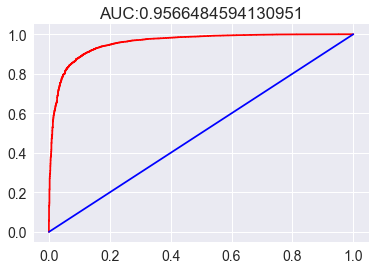

In [99]:
from sklearn.metrics import roc_curve, auc

def plot_roc_auc(actual, preds):
    fpr, tpr, thresholds = roc_curve(actual, preds[:,1])
    plt.plot(fpr,tpr,'r')
    plt.plot([0,1],[0,1],'b')
    plt.title('AUC:{}'.format(auc(fpr,tpr)))
    plt.show()

plot_roc_auc(y_test,lr2.predict_proba(X_test_tfidf))

In [100]:
print(weights_diff[np.where(weights_diff > 64)].size)

2871


2871 features have weight changes greater than 64%

# Feature Importance
Multicolinearity

In [101]:
#Creating a dataframe with feature weights
#df = pd.DataFrame(data = lr2.coef_.reshape(-1,1),index = count_vect.get_feature_names())
word = tfidf_vect.get_feature_names()
coef = lr2.coef_.tolist()[0]
coef_df = pd.DataFrame({'Words':word, 'Coefficient':coef})
coef_df = coef_df.sort_values(['Coefficient','Words'], ascending=[0, 1]) 

In [102]:
#Getting 20 most important positive features.
print("Top 20 Positive Features")
print(coef_df.head(20).to_string(index=False))

Top 20 Positive Features
Words  Coefficient
          great    17.303447
           best    14.853951
         delici    14.079424
           love    13.465455
        perfect    12.046486
          excel    11.505109
 high recommend     9.925848
           nice     9.505823
        favorit     9.179285
           good     9.148196
           amaz     9.082668
         wonder     9.064536
          yummi     7.890514
          tasti     7.564653
         addict     7.456029
         awesom     7.324846
          alway     6.785832
wont disappoint     6.554621
           easi     6.527463
        satisfi     6.477927


In [103]:
#Getting 20 most important negative features.
print("Top 20 Negative Features")
print(coef_df.tail(20).to_string(index=False))

Top 20 Negative Features
Words  Coefficient
     stuck    -6.567770
      mayb    -6.672338
      wors    -6.914106
     sorri    -6.954016
   disgust    -6.992805
     money    -7.229492
  two star    -7.452123
      weak    -7.832975
 tasteless    -7.904558
  wont buy    -8.297113
     threw    -8.406436
     stale    -8.536266
  unfortun    -8.886953
     bland    -9.325325
    return    -9.897846
        aw    -9.939287
   horribl    -9.956765
   terribl   -11.457522
     worst   -14.394850
disappoint   -15.600887


# Feature generation techniques to convert text to vector
TF-IDF Average Word2vec

In [104]:
#splitting data into train and test where 70% data used for train model and 30% for test model
X = final_100k['CleanedText']
print("shape of X:",X.shape)
y = final_100k['Score']
print("shape of y:",y.shape)

#splitting data into train and test where 80% data used for train and 20% for test model

X_train_avgw2v, X_test_avgw2v, y_train_avgw2v, y_test_avgw2v = train_test_split(X,y,test_size=0.2,random_state=0)
print(X_train_avgw2v.shape, y_train_avgw2v.shape, X_test_avgw2v.shape)

shape of X: (100000,)
shape of y: (100000,)
(80000,) (80000,) (20000,)


In [105]:
from gensim.models import Word2Vec
from gensim.models import KeyedVectors

#Train your own word2vec model using your own text corpus of train data
import gensim
i=0
list_of_sent_train=[]
for sent in X_train_avgw2v:
    list_of_sent_train.append(sent.split())
print(list_of_sent_train[0])
print('**********************************')
print(list_of_sent_train[1])

['two', 'himalayan', 'realli', 'hard', 'find', 'realli', 'healthi', 'food', 'like', 'love', 'spa', 'select', 'dri', 'can', 'health', 'problem', 'digest', 'potti', 'problem', 'bladder', 'infect', 'reoccur', 'wonder', 'thank', 'make']
**********************************
['order', 'arriv', 'day', 'place', 'pack', 'realli', 'well', 'styrofoam', 'dri', 'ice', 'stuff', 'pretti', 'good', 'liter', 'disappear', 'mouth', 'tri', 'take', 'big', 'bite', 'let', 'bite', 'complet', 'melt', 'mouth', 'dont', 'swallow', 'melt', 'there', 'noth', 'left', 'weird', 'certain', 'satisfact', 'abl', 'sit', 'whole', 'guiltless', 'pint']


In [106]:
#min_count=5 considers only the words occur atleast 5 times
w2v_model=Word2Vec(list_of_sent_train,min_count=5,size=50,workers=4)
words=list(w2v_model.wv.vocab)
print("number of words that occured 5 times",len(words))

number of words that occured 5 times 11372


In [107]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times",len(w2v_words))
print("sample words",w2v_words[0:50])

number of words that occured minimum 5 times 11372
sample words ['two', 'himalayan', 'realli', 'hard', 'find', 'healthi', 'food', 'like', 'love', 'spa', 'select', 'dri', 'can', 'health', 'problem', 'digest', 'potti', 'bladder', 'infect', 'wonder', 'thank', 'make', 'order', 'arriv', 'day', 'place', 'pack', 'well', 'styrofoam', 'ice', 'stuff', 'pretti', 'good', 'liter', 'disappear', 'mouth', 'tri', 'take', 'big', 'bite', 'let', 'complet', 'melt', 'dont', 'swallow', 'there', 'noth', 'left', 'weird', 'certain']


In [108]:
#average word2vec
#compute average word2vec for each review
sent_vectors_train=[];# the avg-w2v for each sentence/review is stored
for sent in tqdm(list_of_sent_train): #for each review/sentence
    sent_vec=np.zeros(50) #as word vectors are of zero length
    cnt_words=0  #number of words with a valid vector in the review/sentence
    for word in sent: #for each word in a review/sentence
        if word in w2v_words:
            vec=w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
        if cnt_words != 0:
            sent_vec /= cnt_words
    sent_vectors_train.append(sent_vec)
print(len(sent_vectors_train))
print(len(sent_vectors_train[0]))

100%|███████████████████████████████████| 80000/80000 [02:52<00:00, 464.00it/s]


80000
50


In [109]:
from gensim.models import Word2Vec
from gensim.models import KeyedVectors

#Train your own word2vec model using your own text corpus of train data
import gensim
i=0
list_of_sent_test=[]
for sent in X_test_avgw2v:
    list_of_sent_test.append(sent.split())
print(list_of_sent_test[0])
print('**********************************')
print(list_of_sent_test[1])

['love', 'product', 'perfect', 'serv', 'size', 'one', 'count', 'carb', 'dieti', 'also', 'good', 'camp', 'vacat', 'run', 'disappoint', 'condit', 'box', 'complet', 'crunch', 'thank', 'content', 'surviv']
**********************************
['purchas', 'butter', 'chicken', 'curri', 'pack', 'amazon', 'great', 'sale', 'skeptic', 'tast', 'low', 'behold', 'tast', 'way', 'exceed', 'expect', 'meat', 'eater', 'ad', 'tofu', 'cauliflow', 'instead', 'chicken', 'impress', 'authent', 'tast', 'compar', 'restaur', 'weve', 'noth', 'beat', 'fresh', 'unassum', 'packet', 'good', 'could', 'rival', 'indian', 'restaur', 'frequent', 'perfect', 'meal', 'tast', 'price']


In [110]:
#min_count=5 considers only the words occur atleast 5 times
w2v_model=Word2Vec(list_of_sent_test,min_count=5,size=50,workers=4)
words=list(w2v_model.wv.vocab)
print("number of words that occured 5 times",len(words))

number of words that occured 5 times 6228


In [111]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times",len(w2v_words))
print("sample words",w2v_words[0:50])

number of words that occured minimum 5 times 6228
sample words ['love', 'product', 'perfect', 'serv', 'size', 'one', 'count', 'carb', 'also', 'good', 'camp', 'vacat', 'run', 'disappoint', 'condit', 'box', 'complet', 'crunch', 'thank', 'content', 'surviv', 'purchas', 'butter', 'chicken', 'curri', 'pack', 'amazon', 'great', 'sale', 'skeptic', 'tast', 'low', 'behold', 'way', 'exceed', 'expect', 'meat', 'eater', 'ad', 'tofu', 'cauliflow', 'instead', 'impress', 'authent', 'compar', 'restaur', 'weve', 'noth', 'beat', 'fresh']


In [112]:
#average word2vec
#compute average word2vec for each review
sent_vectors_test=[];# the avg-w2v for each sentence/review is stored
for sent in tqdm(list_of_sent_test): #for each review/sentence
    sent_vec=np.zeros(50) #as word vectors are of zero length
    cnt_words=0  #number of words with a valid vector in the review/sentence
    for word in sent: #for each word in a review/sentence
        if word in w2v_words:
            vec=w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
        if cnt_words != 0:
            sent_vec /= cnt_words
    sent_vectors_test.append(sent_vec)
print(len(sent_vectors_test))
print(len(sent_vectors_test[0]))

100%|███████████████████████████████████| 20000/20000 [00:38<00:00, 513.69it/s]


20000
50


In [113]:
len(sent_vectors_train)

80000

In [114]:
len(sent_vectors_test)

20000

# Finding Optimal lambda using GridSearchCV and RandomSearchCV
L1,L2 regularizers using time series CV

In [115]:
%%time
#Importing logistic regression gridsearch and randomsearch
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression

#logreg1 = LogisticRegression(penalty='l1')
#logreg2 = LogisticRegression(penalty='l2')
#parameters we need to try on classifier
param_grid = [{'C':[1000,500,100,50,10,5,1,0.5,0.1,0.05,0.01,0.005,0.001,0.0005,0.0001],'penalty':['l1','l2']}]
#For time based splitting
#tscv = TimeSeriesSplit(n_splits=5)
#performing grid search with l1 regularizer
model1 = GridSearchCV(logreg1,param_grid,cv=5,scoring='f1',verbose=1)
model1.fit(sent_vectors_train,y_train_avgw2v)
#Using grid search to find optimal C or 1/lambda
print("Best Hyper parameter:", model1.best_params_)
print("Best accuracy score:" ,(model1.best_score_*100))

Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:  2.2min finished


Best Hyper parameter: {'C': 0.01, 'penalty': 'l2'}
Best accuracy score: 93.46659388990791
Wall time: 2min 11s


Accuracy on test data: 87.71
Precision on test data: 87.71438571928596
Recall on test data: 99.99429972068631
F1-score on test data: 93.45266634702466
Non zero weights: 50
Confusion Matrix of test data:



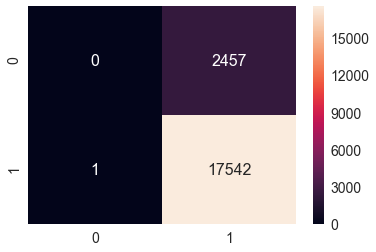

In [116]:
#Testing accuracy on test data
logreg =LogisticRegression(C = 0.01, penalty = 'l2')
logreg.fit(sent_vectors_train,y_train_avgw2v)
y_pred = logreg.predict(sent_vectors_test)
print("Accuracy on test data:" ,(accuracy_score(y_test_avgw2v,y_pred)*100))
print("Precision on test data:" ,(precision_score(y_test_avgw2v,y_pred)*100))
print("Recall on test data:" ,(recall_score(y_test_avgw2v,y_pred)*100))
print("F1-score on test data:" ,(f1_score(y_test_avgw2v,y_pred)*100))
print("Non zero weights:" ,np.count_nonzero(logreg.coef_))
print("Confusion Matrix of test data:\n")
df_cm = pd.DataFrame(confusion_matrix(y_test_avgw2v,y_pred),range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size":16},fmt='g')

In [117]:
logreg =LogisticRegression(C = 10 , penalty = 'l1')
logreg.fit(sent_vectors_train,y_train_avgw2v)
y_pred = logreg.predict(sent_vectors_test)
print("Accuracy on test data:" ,(accuracy_score(y_test_avgw2v,y_pred)*100))
print("Precision on test data:" ,(precision_score(y_test_avgw2v,y_pred)*100))
print("Recall on test data:" ,(recall_score(y_test_avgw2v,y_pred)*100))
print("F1-score on test data:" ,(f1_score(y_test_avgw2v,y_pred)*100))
print("Non zero weights:" ,np.count_nonzero(logreg.coef_))

Accuracy on test data: 87.705
Precision on test data: 87.71377137713772
Recall on test data: 99.98859944137263
F1-score on test data: 93.44982818784796
Non zero weights: 49


Checking sparsity with differernt values of lambda or C

In [118]:
c_sparse = np.arange(0,50,0.5)
c_sparse = c_sparse[1:]
c_sparse.shape

(99,)

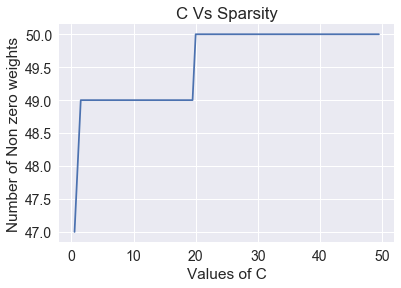

In [119]:
spc = []#Number of sparsity counts(Non zero weights for a given C)
error = []
for c in c_sparse:
    lr = LogisticRegression(penalty='l1',C=c)
    lr.fit(sent_vectors_train,y_train_avgw2v)
    error.append(1-lr.score(sent_vectors_test,y_test_avgw2v))
    spc.append(np.count_nonzero(lr.coef_))
#Plotting C vs Sparsity
plt.title("C Vs Sparsity")
plt.xlabel("Values of C")
plt.ylabel("Number of Non zero weights")
plt.plot(c_sparse,spc)
plt.show()

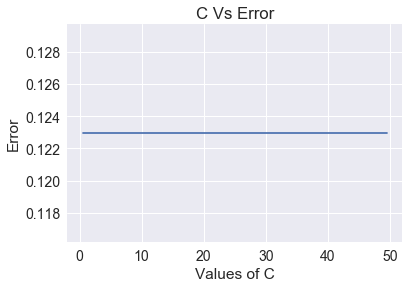

In [120]:
#Plotting C vs Sparsity
plt.title("C Vs Error")
plt.xlabel("Values of C")
plt.ylabel("Error")
plt.plot(c_sparse,error)
plt.show()

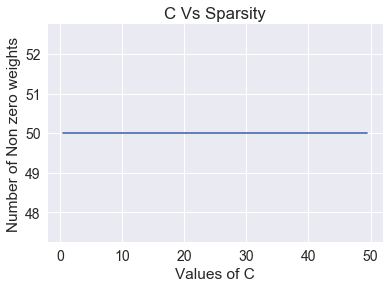

In [121]:
spc = []#Number of sparsity counts(Non zero weights for a given C)
error = []
for c in c_sparse:
    lr = LogisticRegression(penalty='l2',C=c)
    lr.fit(sent_vectors_train,y_train_avgw2v)
    error.append(1-lr.score(sent_vectors_test,y_test_avgw2v))
    spc.append(np.count_nonzero(lr.coef_))
#Plotting C vs Sparsity
plt.title("C Vs Sparsity")
plt.xlabel("Values of C")
plt.ylabel("Number of Non zero weights")
plt.plot(c_sparse,spc)
plt.show()

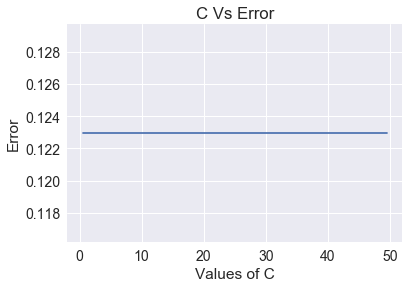

In [122]:
#Plotting C vs Sparsity
plt.title("C Vs Error")
plt.xlabel("Values of C")
plt.ylabel("Error")
plt.plot(c_sparse,error)
plt.show()

In [123]:
%%time
#Importing logistic regression gridsearch and randomsearch
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression

#logreg1 = LogisticRegression(penalty='l1')
#logreg2 = LogisticRegression(penalty='l2')
#parameters we need to try on classifier
param_grid = {'C':[1000,500,100,50,10,5,1,0.5,0.1,0.05,0.01,0.005,0.001,0.0005,0.0001],'penalty':['l1','l2']}
#For time based splitting
#tscv = TimeSeriesSplit(n_splits=5)
#performing grid search with l1 regularizer
model1 = RandomizedSearchCV(logreg1,param_grid,cv=5,scoring='f1',verbose=1)
model1.fit(sent_vectors_train,y_train_avgw2v)
#Using grid search to find optimal C or 1/lambda
print("Best Hyper parameter:", model1.best_params_)
print("Best accuracy score:" ,(model1.best_score_*100))

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:   48.1s finished


Best Hyper parameter: {'penalty': 'l2', 'C': 0.01}
Best accuracy score: 93.46659388990791
Wall time: 49 s


Accuracy on test data: 87.71
Precision on test data: 87.71438571928596
Recall on test data: 99.99429972068631
F1-score on test data: 93.45266634702466
Non zero weights: 50
Confusion Matrix of test data:



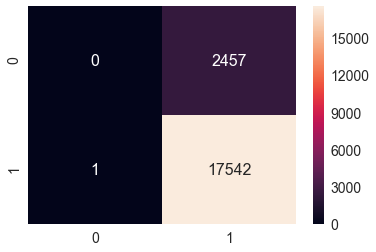

In [124]:
#Testing accuracy on test data
logreg =LogisticRegression(C = 0.01, penalty = 'l2')
logreg.fit(sent_vectors_train,y_train_avgw2v)
y_pred = logreg.predict(sent_vectors_test)
print("Accuracy on test data:" ,(accuracy_score(y_test_avgw2v,y_pred)*100))
print("Precision on test data:" ,(precision_score(y_test_avgw2v,y_pred)*100))
print("Recall on test data:" ,(recall_score(y_test_avgw2v,y_pred)*100))
print("F1-score on test data:" ,(f1_score(y_test_avgw2v,y_pred)*100))
print("Non zero weights:" ,np.count_nonzero(logreg.coef_))
print("Confusion Matrix of test data:\n")
df_cm = pd.DataFrame(confusion_matrix(y_test_avgw2v,y_pred),range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size":16},fmt='g')

# Feature generation techniques to convert text to vector
TF-IDF Weighted Word2vec

In [125]:
#splitting data into train and test where 80% data used for train model and 20% for test model
X = final_100k['CleanedText']
print("shape of X:",X.shape)
y = final_100k['Score']
print("shape of y:",y.shape)
X_train_wtdw2v, X_test_wtdw2v, y_train_wtdw2v, y_test_wtdw2v = train_test_split(X,y,test_size=0.2,random_state=0)
print(X_train_wtdw2v.shape, y_train_wtdw2v.shape, X_test_wtdw2v.shape)

shape of X: (100000,)
shape of y: (100000,)
(80000,) (80000,) (20000,)


In [126]:
model = TfidfVectorizer()
X_train_wtdw2v = model.fit_transform(X_train_wtdw2v)
#we are converting a dictionary with word as a key, and the idf as a value
#dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [127]:
X_test_wtdw2v = model.transform(X_test_wtdw2v)
#we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [128]:
#TF-IDF weighted word2vec
tfidf_feat=model.get_feature_names()
#tfidf words/col-names
#final_tf_idf is the sparse matrix with row=sentence,col=word and cell_val=tfidf
tfidf_sent_vectors_train=[]
row=0
for sent in tqdm(list_of_sent_train): #for each review/sentence
    sent_vec=np.zeros(50) #as word vectors are of zero length
    weight_sum=0  #num of words with a valid vector in the sentence/review
    for word in sent:   #for each word in a review/sentence
        if word in w2v_words:  
            vec=w2v_model.wv[word]#to reduce the computation we are
            tf_idf=dictionary[word]*(sent.count(word)/len(sent))#dictionary[word] = idf value of word in whole corpus
            sent_vec += (vec*tf_idf) #sent.count(word)= tf values of word in this review
            weight_sum += tf_idf
    if weight_sum !=0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_train.append(sent_vec)
    row +=1
print(len(tfidf_sent_vectors_train))
print(len(tfidf_sent_vectors_train[0]))

100%|███████████████████████████████████| 80000/80000 [02:53<00:00, 460.60it/s]


80000
50


In [129]:
#TF-IDF weighted word2vec
tfidf_feat=model.get_feature_names()
#tfidf words/col-names
#final_tf_idf is the sparse matrix with row=sentence,col=word and cell_val=tfidf
tfidf_sent_vectors_test=[]
row=0
for sent in tqdm(list_of_sent_test): #for each review/sentence
    sent_vec=np.zeros(50) #as word vectors are of zero length
    weight_sum=0  #num of words with a valid vector in the sentence/review
    for word in sent:   #for each word in a review/sentence
        if word in w2v_words:  
            vec=w2v_model.wv[word]#to reduce the computation we are
            tf_idf=dictionary[word]*(sent.count(word)/len(sent))#dictionary[word] = idf value of word in whole corpus
            sent_vec += (vec*tf_idf) #sent.count(word)= tf values of word in this review
            weight_sum += tf_idf
    if weight_sum !=0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_test.append(sent_vec)
    row +=1
print(len(tfidf_sent_vectors_test))
print(len(tfidf_sent_vectors_test[0]))

100%|███████████████████████████████████| 20000/20000 [00:46<00:00, 427.90it/s]


20000
50


In [130]:
X_train_wtdw2v=tfidf_sent_vectors_train
X_test_wtdw2v=tfidf_sent_vectors_test

# Finding Optimal lambda using GridSearchCV and RandomSearchCV
L1,L2 regularizers using time series CV

In [131]:
%%time
#Importing logistic regression gridsearch and randomsearch
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression

#logreg1 = LogisticRegression(penalty='l1')
#logreg2 = LogisticRegression(penalty='l2')
#parameters we need to try on classifier
param_grid = [{'C':[1000,500,100,50,10,5,1,0.5,0.1,0.05,0.01,0.005,0.001,0.0005,0.0001],'penalty':['l1','l2']}]
#For time based splitting
#tscv = TimeSeriesSplit(n_splits=5)
#performing grid search with l1 regularizer
model1 = GridSearchCV(logreg1,param_grid,cv=5,scoring='f1',verbose=1)
model1.fit(X_train_wtdw2v,y_train_wtdw2v)
#Using grid search to find optimal C or 1/lambda
print("Best Hyper parameter:", model1.best_params_)
print("Best accuracy score:" ,(model1.best_score_*100))

Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed: 23.2min finished


Best Hyper parameter: {'C': 10, 'penalty': 'l1'}
Best accuracy score: 93.88682449946293
Wall time: 23min 48s


Accuracy on test data: 88.82
Precision on test data: 90.04761655591021
Recall on test data: 98.09610670922875
F1-score on test data: 93.89971080918862
Non zero weights: 50
Confusion Matrix of test data:



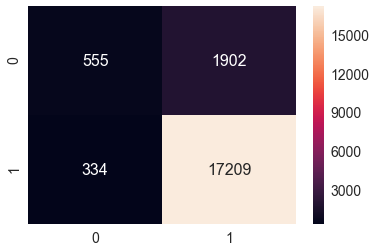

In [132]:
#Testing accuracy on test data
logreg =LogisticRegression(C = 10, penalty = 'l1')
logreg.fit(X_train_wtdw2v,y_train_wtdw2v)
y_pred = logreg.predict(X_test_wtdw2v)
print("Accuracy on test data:" ,(accuracy_score(y_test_wtdw2v,y_pred)*100))
print("Precision on test data:" ,(precision_score(y_test_wtdw2v,y_pred)*100))
print("Recall on test data:" ,(recall_score(y_test_wtdw2v,y_pred)*100))
print("F1-score on test data:" ,(f1_score(y_test_wtdw2v,y_pred)*100))
print("Non zero weights:" ,np.count_nonzero(logreg.coef_))
print("Confusion Matrix of test data:\n")
df_cm = pd.DataFrame(confusion_matrix(y_test_wtdw2v,y_pred),range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size":16},fmt='g')

In [133]:
logreg =LogisticRegression(C = 5 , penalty = 'l1')
logreg.fit(X_train_wtdw2v,y_train_wtdw2v)
y_pred = logreg.predict(X_test_wtdw2v)
print("Accuracy on test data:" ,(accuracy_score(y_test_wtdw2v,y_pred)*100))
print("Precision on test data:" ,(precision_score(y_test_wtdw2v,y_pred)*100))
print("Recall on test data:" ,(recall_score(y_test_wtdw2v,y_pred)*100))
print("F1-score on test data:" ,(f1_score(y_test_wtdw2v,y_pred)*100))
print("Non zero weights:" ,np.count_nonzero(logreg.coef_))

Accuracy on test data: 88.83
Precision on test data: 90.05284914447176
Recall on test data: 98.10180698854244
F1-score on test data: 93.90516723959186
Non zero weights: 50


In [134]:
c_sparse = np.arange(0,50,0.5)
c_sparse = c_sparse[1:]
c_sparse.shape

(99,)

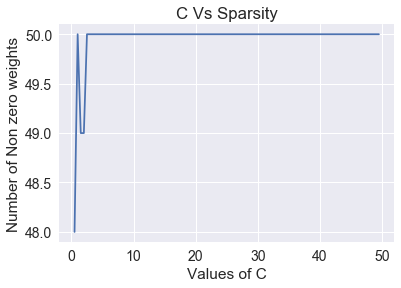

In [135]:
spc = []#Number of sparsity counts(Non zero weights for a given C)
error = []
for c in c_sparse:
    lr = LogisticRegression(penalty='l1',C=c)
    lr.fit(X_train_wtdw2v,y_train_wtdw2v)
    error.append(1-lr.score(X_test_wtdw2v,y_test_wtdw2v))
    spc.append(np.count_nonzero(lr.coef_))
#Plotting C vs Sparsity
plt.title("C Vs Sparsity")
plt.xlabel("Values of C")
plt.ylabel("Number of Non zero weights")
plt.plot(c_sparse,spc)
plt.show()

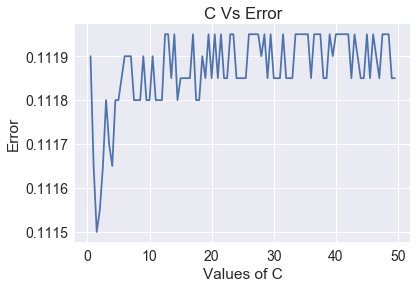

In [136]:
#Plotting C vs Sparsity
plt.title("C Vs Error")
plt.xlabel("Values of C")
plt.ylabel("Error")
plt.plot(c_sparse,error)
plt.show()

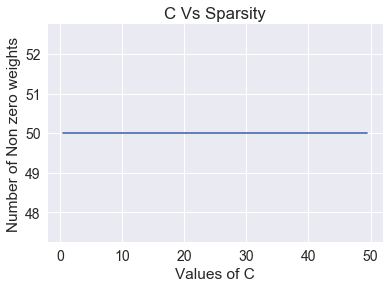

In [137]:
spc = []#Number of sparsity counts(Non zero weights for a given C)
error = []
for c in c_sparse:
    lr = LogisticRegression(penalty='l2',C=c)
    lr.fit(X_train_wtdw2v,y_train_wtdw2v)
    error.append(1-lr.score(X_test_wtdw2v,y_test_wtdw2v))
    spc.append(np.count_nonzero(lr.coef_))
#Plotting C vs Sparsity
plt.title("C Vs Sparsity")
plt.xlabel("Values of C")
plt.ylabel("Number of Non zero weights")
plt.plot(c_sparse,spc)
plt.show()

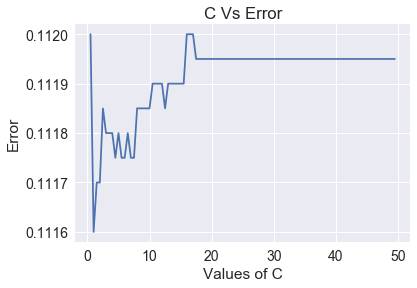

In [138]:
#Plotting C vs Sparsity
plt.title("C Vs Error")
plt.xlabel("Values of C")
plt.ylabel("Error")
plt.plot(c_sparse,error)
plt.show()

In [139]:
%%time
#Importing logistic regression gridsearch and randomsearch
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression

#logreg1 = LogisticRegression(penalty='l1')
#logreg2 = LogisticRegression(penalty='l2')
#parameters we need to try on classifier
param_grid = {'C':[1000,500,100,50,10,5,1,0.5,0.1,0.05,0.01,0.005,0.001,0.0005,0.0001],'penalty':['l1','l2']}
#For time based splitting
#tscv = TimeSeriesSplit(n_splits=5)
#performing grid search with l1 regularizer
model1 = RandomizedSearchCV(logreg1,param_grid,cv=5,scoring='f1',verbose=1)
model1.fit(X_train_wtdw2v,y_train_wtdw2v)
#Using grid search to find optimal C or 1/lambda
print("Best Hyper parameter:", model1.best_params_)
print("Best accuracy score:" ,(model1.best_score_*100))

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed: 11.0min finished


Best Hyper parameter: {'penalty': 'l1', 'C': 10}
Best accuracy score: 93.88699403110954
Wall time: 11min 28s


Accuracy on test data: 88.81
Precision on test data: 90.04238396734866
Recall on test data: 98.09040642991506
F1-score on test data: 93.8942543787854
Non zero weights: 50
Confusion Matrix of test data:



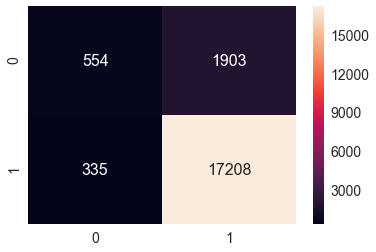

In [140]:
#Testing accuracy on test data
logreg =LogisticRegression(C = 10, penalty = 'l1')
logreg.fit(X_train_wtdw2v,y_train_wtdw2v)
y_pred = logreg.predict(X_test_wtdw2v)
print("Accuracy on test data:" ,(accuracy_score(y_test_wtdw2v,y_pred)*100))
print("Precision on test data:" ,(precision_score(y_test_wtdw2v,y_pred)*100))
print("Recall on test data:" ,(recall_score(y_test_wtdw2v,y_pred)*100))
print("F1-score on test data:" ,(f1_score(y_test_wtdw2v,y_pred)*100))
print("Non zero weights:" ,np.count_nonzero(logreg.coef_))
print("Confusion Matrix of test data:\n")
df_cm = pd.DataFrame(confusion_matrix(y_test_avgw2v,y_pred),range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size":16},fmt='g')

Observation:
    Featurization               CV                    Accuracy              F1-Score               C             Penalty
    =====================================================================================================================
    BOW                    GridSearchCV                 92                     95                  50             L2
                           RandomizedSearchCV           92                     95                  50             L2 
                           
    TFIDF                  GridSearchCV                 93.5                   96                  5              L1             
                           RandomizedSearchCV           93.1                   96                  100            L2
                           
    AVG Word2Vec           GridSearchCV                 87                     93                  0.01           L2
                           RandomizedSearchCV           87                     93                  0.01           L2
                           
    Wtd Word2Vec           GridSearchCV                 88                     93                  10             L1
                           RandomizedSearchCV           88                     93                  10             L1

Conclusion:
    Features are multicollinear for BOW and tfidf ,they are co-related and for BOW and Tfidf weights difference is 234 and 2871.
    BOW and Tfidf Featuriation shows best accuracy as 92% and 93% and for F1-score as 95% and 96%.
    Sparsity increases as we increase lambda or decrease C when L2 regulariation is used.
    For Avg word2vec its showing biased results towards positive for both grid search and randomized search. 